<a href="https://colab.research.google.com/github/cccadet/dermatologist-ai/blob/master/01_Train1_ISIC_2019_DeepStack_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pré: Conexão com Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Etapa 1: Instalação das dependências

### Instalação de bibliotecas

In [2]:
!pip install tensorflow-gpu
!pip install tqdm
#!pip install tensorflow-addons
!pip install tfa-nightly
!pip install deepstack

     |████████████████████████████████| 320.4MB 18kB/s 
     |████████████████████████████████| 1.1MB 3.5MB/s 


### Importação das bibliotecas

In [3]:
import zipfile
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import pandas as pd
import sys
import itertools
import shutil

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
tf.__version__

'2.3.0'

### Otimizações tensorflow

In [4]:
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)
tf.config.optimizer.set_jit(True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Fazendo o download da base de dados de imagens

In [5]:
%%time
if (os.path.isdir('./ISIC_Training_Input')==False):
  !wget --no-check-certificate \
      https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip \
      -O ./skin_cancer_train_2018.zip


--2020-08-11 11:40:48--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.17.104
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.17.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2771732744 (2.6G) [application/zip]
Saving to: ‘./skin_cancer_train_2018.zip’

./skin_cancer_train 100%[===================>]   2.58G  26.6MB/s    in 43s     

2020-08-11 11:41:32 (60.8 MB/s) - ‘./skin_cancer_train_2018.zip’ saved [2771732744/2771732744]

CPU times: user 291 ms, sys: 106 ms, total: 397 ms
Wall time: 46.6 s


In [6]:
%%time
if (os.path.isdir('./ISIC_Training_Input')==False):
  !wget --no-check-certificate \
      https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip \
      -O ./skin_cancer_train_2019.zip

--2020-08-11 11:41:34--  https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.139.149
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.139.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9771618190 (9.1G) [application/zip]
Saving to: ‘./skin_cancer_train_2019.zip’

./skin_cancer_train 100%[===================>]   9.10G  43.3MB/s    in 4m 3s   

2020-08-11 11:45:37 (38.4 MB/s) - ‘./skin_cancer_train_2019.zip’ saved [9771618190/9771618190]

CPU times: user 1.49 s, sys: 575 ms, total: 2.06 s
Wall time: 4min 4s


## Etapa 2: Pré-processamento

### Configurando os caminhos (paths)

In [7]:
train_dir = "./train"
if not os.path.exists(train_dir): 
  os.mkdir(train_dir)
valid_dir = "./valid"
if not os.path.exists(valid_dir): 
  os.mkdir(valid_dir)


download_path = './'
derm_ai_path = '/content/drive/My Drive/Derm AI/ISIC_2019'


### Definindo função para descompactar arquivo

In [8]:
def dcp(download_path, path, file):
  if (os.path.isdir(path)==False):
    dataset_path = os.path.join(download_path,file)
    zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
    zip_object.extractall("./")
    zip_object.close()

### Descompactando a base de dados de Treinamento

In [9]:
%%time
dcp(download_path, './ISIC2018_Task3_Training_Input', 'skin_cancer_train_2018.zip')

CPU times: user 7.81 s, sys: 4.92 s, total: 12.7 s
Wall time: 1min 28s


In [10]:
!rm ./skin_cancer_train_2018.zip

In [11]:
%%time
dcp(download_path, './ISIC_2019_Training_Input', 'skin_cancer_train_2019.zip')

CPU times: user 54.3 s, sys: 17.2 s, total: 1min 11s
Wall time: 4min 52s


In [12]:
!rm ./skin_cancer_train_2019.zip

### Definindo DataFrame base para criação das pastas de cada classe

In [13]:
!wget --no-check-certificate \
      https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip \
      -O ./ground_truth.zip


zip_object = zipfile.ZipFile(file='ground_truth.zip', mode="r")
zip_object.extractall("./")
zip_object.close()

--2020-08-11 11:52:03--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.140.100
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.140.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36681 (36K) [application/zip]
Saving to: ‘./ground_truth.zip’

./ground_truth.zip  100%[===================>]  35.82K  --.-KB/s    in 0.03s   

2020-08-11 11:52:03 (1.19 MB/s) - ‘./ground_truth.zip’ saved [36681/36681]



In [14]:
# Read in the data
ground_truth1 = pd.read_csv('https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv')
ground_truth2 = pd.read_csv('/content/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')
ground_truth2['AK'] = ground_truth2['AKIEC']
ground_truth2.drop(columns=['AKIEC'], inplace=True)
ground_truth = pd.concat([ground_truth1,ground_truth2])

# Display some information in the dataset
ground_truth.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
!mkdir ISIC_Training_Input
!mv /content/ISIC2018_Task3_Training_Input/*.jpg /content/ISIC_Training_Input
!mv /content/ISIC_2019_Training_Input/*.jpg /content/ISIC_Training_Input

### Separando base de treinamento e de validação

In [16]:
# Set y as the labels
y = []
for row in ground_truth.iterrows():
    innerlist = []
    newlist = row[1].index[row[1].values[1:].argmax() + 1]
    y.append(newlist)


#add a name to the label series
yd = pd.Series(y) 
yd.name = 'cclass'

from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(ground_truth, test_size=0.2, random_state=41, stratify=yd)

# Get a list of images in each of the two folders
folder = os.listdir('ISIC_Training_Input')

# Get a list of train and val images
#all_list = list(ground_truth['image'])
#
train_list = list(df_train['image'])
val_list = list(df_val['image'])

### Criando subdiretório das classes

In [17]:
#create sub directory for the classes
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        dir_path = os.path.join(train_dir, col)
        if not os.path.exists(dir_path):
          os.mkdir(dir_path)
        dir_path = os.path.join(valid_dir, col)
        if not os.path.exists(dir_path):
          os.mkdir(dir_path)

### Transferindo arquivos - base de treinamento

In [18]:
%%time
# Transfer the training images
for row in df_train.iterrows():
    image = row[1].image
    # The argmax error was occuring because the first column (image) is a string.
    # By using row[1].values[1:] we skip the first column.  This means we need 
    # add 1 to get the correct row[1].index.
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'

    if fname in folder:
        # source path to image
        src = os.path.join('ISIC_Training_Input', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

CPU times: user 18.4 s, sys: 16.7 s, total: 35.1 s
Wall time: 3min 52s


### Transferindo arquivos - base de validação

In [19]:
%%time
# Transfer the valid images
for row in df_val.iterrows():
    image = row[1].image
    # The argmax error was occuring because the first column (image) is a string.
    # By using row[1].values[1:] we skip the first column.  This means we need 
    # add 1 to get the correct row[1].index.
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'

    if fname in folder:
        # source path to image
        src = os.path.join('ISIC_Training_Input', fname)
        # destination path to image
        dst = os.path.join(valid_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

CPU times: user 4.53 s, sys: 4.23 s, total: 8.76 s
Wall time: 1min 3s


### Números das bases de treinamento

In [20]:
# training examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(train_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)

MEL 3790
NV 11392
BCC 2749
AK 874
BKL 2277
DF 211
VASC 233
SCC 502
total =  22028


### Números das bases de validação

In [21]:
# validation examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(valid_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)

MEL 1086
NV 3637
BCC 746
AK 231
BKL 701
DF 67
VASC 75
SCC 126
total =  6669


### Balanceamento base de validação

In [22]:
import os, random
mellen = len(os.listdir('./valid/MEL'))
nvlen = len(os.listdir('./valid/NV'))
for i in range(nvlen - mellen):
    file = random.choice(os.listdir("./valid/NV"))
    dst = os.path.join(valid_dir,'NV', file)
    os.remove(dst)

In [23]:
# validation examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(valid_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)        
val_len = total

MEL 1086
NV 1086
BCC 746
AK 231
BKL 701
DF 67
VASC 75
SCC 126
total =  4118


AK
BCC
BKL
DF
MEL Melanoma
NV
SCC
VASC

### Criando pesos das classes

### Criando geradores de dados (Data Generators)


In [24]:
# Data Augmentation (https://keras.io/preprocessing/image/)
data_gen_train = ImageDataGenerator(#validation_split=0.2,
                                    rescale=1/255., 
                                    horizontal_flip= True, 
                                    vertical_flip = True, 
                                    height_shift_range=0.10, 
                                    width_shift_range=0.10,
                                    rotation_range=180,
                                    shear_range=0.01,
                                    zoom_range=[0.95, 1.25],
                                    fill_mode='constant',
                                    #data_format='channels_last',
                                    brightness_range=[0.9, 1.1]
                                    )

data_gen_valid = ImageDataGenerator(rescale=1/255., 
                                   fill_mode="constant"
)



In [25]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(299,299), batch_size=32, class_mode="categorical")
valid_generator = data_gen_valid.flow_from_directory(valid_dir, target_size=(299,299), batch_size=32, class_mode="categorical")

Found 22028 images belonging to 8 classes.
Found 4118 images belonging to 8 classes.


#### Exibição de 3 imagens carregadas

[0. 0. 0. 0. 1. 0. 0. 0.]


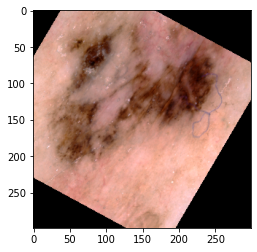

[0. 0. 0. 0. 0. 1. 0. 0.]


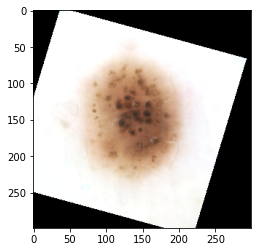

[0. 0. 0. 0. 0. 1. 0. 0.]


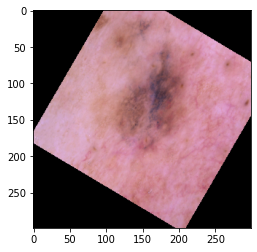

In [26]:
x,y = train_generator.next()
for i in range(0,3):
    image = x[i]
    label = y[i]
    print (label)
    plt.imshow(image)
    plt.show()

In [27]:
import numpy as np

from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(train_generator.classes), class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes))) 


class_weights
train_generator.class_indices

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

## Etapa 3: Construindo o modelo

In [29]:
model1 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'model1_B7'))
model2 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'model2_InceptionResnetV2'))
#model3 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'model3_NasNet_Large'))
model4 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'model4_InceptionV3'))
#model5 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'model5_Xception'))
#model6 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'B1-IRN50V2_4'))

In [30]:
%%time
from deepstack.base import KerasMember

member1 = KerasMember(name="model1", keras_model=model1, train_batches=train_generator, val_batches=valid_generator)
member2 = KerasMember(name="model2", keras_model=model2, train_batches=train_generator, val_batches=valid_generator)
#member3 = KerasMember(name="model3", keras_model=model3, train_batches=train_generator, val_batches=valid_generator)
member4 = KerasMember(name="model4", keras_model=model4, train_batches=train_generator, val_batches=valid_generator)
#member5 = KerasMember(name="model5", keras_model=model5, train_batches=train_generator, val_batches=valid_generator)
#member6 = KerasMember(name="model6", keras_model=model6, train_batches=train_generator, val_batches=valid_generator)


Instructions for updating:
Please use Model.predict, which supports generators.
129/129 [==============================] - 67s 520ms/step
CPU times: user 47min 35s, sys: 2min 58s, total: 50min 34s
Wall time: 45min 17s


### Definindo o modelo

In [31]:
%%time
from deepstack.ensemble import DirichletEnsemble

wAvgEnsemble = DirichletEnsemble()
#wAvgEnsemble.add_members([member1, member2, member3, member4, member5])
wAvgEnsemble.add_members([member1, member2, member4])
wAvgEnsemble.fit()
wAvgEnsemble.describe()

model1 - Weight: 0.0024 - roc_auc_score: 0.8474
model2 - Weight: 0.8493 - roc_auc_score: 0.9517
model4 - Weight: 0.1482 - roc_auc_score: 0.9310
DirichletEnsemble roc_auc_score: 0.9525
CPU times: user 2min 1s, sys: 55.3 ms, total: 2min 1s
Wall time: 2min 1s


### Matriz de Validação

In [32]:
#valid_loss, valid_acc = model5.evaluate(valid_generator)
#valid_acc

In [34]:
#License: MIT
from deepstack.ensemble import StackEnsemble
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#Ensure you have the scikit-learn version >= 0.22 installed
print("sklearn version must be >= 0.22. You have:", sklearn.__version__)

stack = StackEnsemble()

# 2nd Level Meta-Learner
estimators = [
    ('rf', RandomForestClassifier(verbose=0, n_estimators=200, max_depth=15, n_jobs=20, min_samples_split=30)),
    ('etr', ExtraTreesClassifier(verbose=0, n_estimators=200, max_depth=10, n_jobs=20, min_samples_split=20))
]
# 3rd Level Meta-Learner
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

stack.model = clf
stack.add_members([member1, member2, member4])
stack.fit()
stack.describe(metric=sklearn.metrics.accuracy_score)

sklearn version must be >= 0.22. You have: 0.22.2.post1


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Calling predict
model1 - accuracy_score: 0.8474
model2 - accuracy_score: 0.9517
model4 - accuracy_score: 0.9310
StackEnsemble accuracy_score: 0.7171


0.717095677513356

In [42]:
# Create a confusion matrix of the test images
val_labels = valid_generator.classes
# Make predictions
val_predictions = wAvgEnsemble.predict(valid_generator)

TypeError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix

# Declare a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(val_labels, val_predictions.argmax(axis=1))

cm_plot_labels = ['AK' , 'BCC' , 'BKL' , 'DF' , 'MEL' , 'NV' , 'SCC'	, 'VASC']

plot_confusion_matrix(cm, cm_plot_labels)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

val_accuracy = 100*np.sum(val_predictions == val_labels)/len(val_predictions)
print('\nTest accuracy: %.2f%%' % val_accuracy)
#

balanced_accuracy = balanced_accuracy_score(val_labels, val_predictions)
print('\nBalanced accuracy: {:.3f}'.format(balanced_accuracy) )

### Execução das predições na base de testes

### Identificar classe predita

In [ ]:
def predClasses(pred, train_generator):
  predicted_class_indices=np.argmax(pred,axis=1)

  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in predicted_class_indices]
  return predicted_class_indices, labels, predictions

predicted_class_indices, labels, predictions = predClasses(pred, train_generator)